# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [129]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import json

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)


In [130]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [131]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [132]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


#### Clean Nulls

In [133]:
portfolio.isna().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [135]:
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [154]:
profile.isna().sum()/profile.shape[0]

gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

In [156]:
profile=profile.dropna()

#### Finding outliers

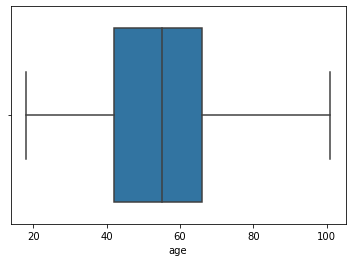

In [160]:
import seaborn as sns
sns.boxplot(x=profile["age"])

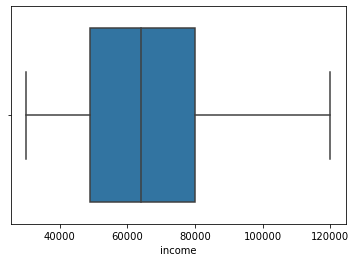

In [161]:
sns.boxplot(x=profile["income"])

#### AAAAAAA

In [163]:
transcript["event"].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [164]:
def reward(a):
    if("reward" in a.keys()):
        return a["reward"]
    return None

def amount(a):
    if("amount" in a.keys()):
        return a["amount"]
    return None

def offer_id(a):
    if("offer id" in a.keys()):
        return a["offer id"]
    elif("offer_id" in a.keys()):
        return a["offer_id"]
    return None

transcript["event"]=transcript["event"].map(lambda x: x.replace("offer ",""))
transcript["offer"]=transcript["value"].map(offer_id)
transcript["reward"]=transcript["value"].map(reward)
transcript["amount"]=transcript["value"].map(amount)
transcript=transcript.drop(['value'], axis=1)
transcript

,person,event,time,offer,reward,amount
0,78afa995795e4d85b5d9ceeca43f5fef,received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,None,NaN,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,None,NaN,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,714,None,NaN,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,None,NaN,3.53


In [85]:
def count_element(a):
    suma=0
    for key in a.keys():
        if(type(a[key])=="list"):
            suma=suma+len(a[key])
        else:
            suma=suma+1
    return suma

In [88]:
transcript["element"]=transcript["value"].map(count_element)
max(transcript["element"])

2

In [89]:
pp=transcript["value"].values
set().union(*(d.keys() for d in pp))

{'amount', 'offer id', 'offer_id', 'reward'}

### EDA

#### % OFFER

In [9]:
transcript.head()

,person,event,time,offer,reward,amount
0,78afa995795e4d85b5d9ceeca43f5fef,received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [24]:
total=transcript.shape[0]
porc_received=(transcript[transcript["event"]=="received"].shape[0]/total)*100
porc_completed=(transcript[transcript["event"]=="completed"].shape[0]/total)*100
porc_viewed=(transcript[transcript["event"]=="viewed"].shape[0]/total)*100
porc_transaction=(transcript[transcript["event"]=="transaction"].shape[0]/total)*100

<BarContainer object of 4 artists>

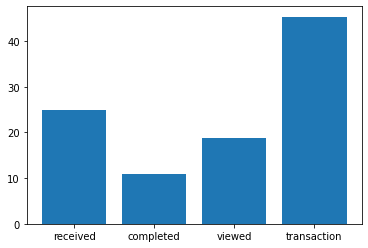

In [28]:
x=["received","completed","viewed","transaction"]
height=[porc_received,porc_completed,porc_viewed,porc_transaction]
plt.bar(x, height)

#### % OFFER completed by type

In [121]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [124]:
completed=transcript[transcript["event"]=="completed"]
merge=pd.merge(portfolio,completed, left_on=['id'], right_on=['offer'], how='left')
merge=merge.groupby(["offer_type","difficulty","duration","reward_x"]).count()["id"].reset_index()
merge

,offer_type,difficulty,duration,reward_x,id
0,bogo,5,5,5,4296
1,bogo,5,7,5,4354
2,bogo,10,5,10,3331
3,bogo,10,7,10,3688
4,discount,7,7,3,5156
5,discount,10,7,2,4017
6,discount,10,10,2,5317
7,discount,20,10,5,3420
8,informational,0,3,0,1
9,informational,0,4,0,1


<BarContainer object of 10 artists>

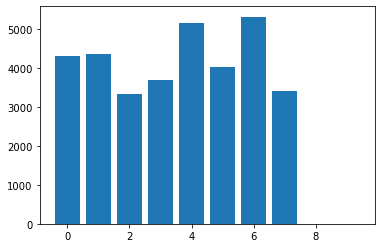

In [127]:
def func(row): 
    return row["offer_type"] +"_"+ str(row["difficulty"]) +"_"+ str(row["duration"])+"_"+ str(row["reward_x"])


merge["name_offer"]=range(0,10)
plt.bar(merge["name_offer"], merge["id"])

#### Range Age depend of offer completed

(array([2622., 3070., 4750., 8334., 8079., 5000., 2461.,  895.,   72.,
        2522.]),
 array([ 18.,  28.,  38.,  48.,  58.,  68.,  78.,  88.,  98., 108., 118.]),
 <a list of 10 Patch objects>)

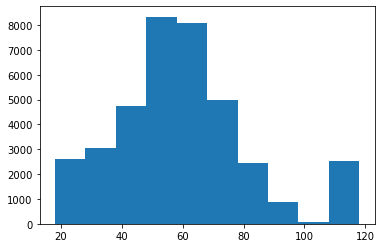

In [82]:
merge=pd.merge(profile,completed, left_on=['id'], right_on=['person'], how='left')
plt.hist(merge["age"])

(array([13465., 14583., 18173., 26344., 25477., 15717.,  7585.,  2710.,
          236., 15085.]),
 array([ 18.,  28.,  38.,  48.,  58.,  68.,  78.,  88.,  98., 108., 118.]),
 <a list of 10 Patch objects>)

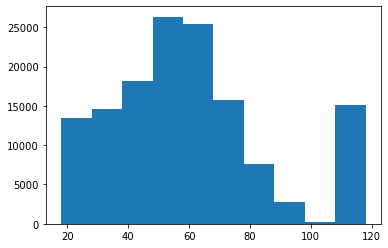

In [85]:
transaction=transcript[transcript["event"]=="transaction"]
merge=pd.merge(profile,transaction, left_on=['id'], right_on=['person'], how='left')
plt.hist(merge["age"])

#### Depend Income of people

(array([3261., 3312., 5026., 5145., 5745., 3867., 3431., 2756., 1418.,
        1322.]),
 array([ 30000.,  39000.,  48000.,  57000.,  66000.,  75000.,  84000.,
         93000., 102000., 111000., 120000.]),
 <a list of 10 Patch objects>)

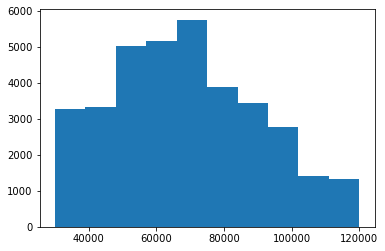

In [86]:
merge=pd.merge(profile,completed, left_on=['id'], right_on=['person'], how='left')
plt.hist(merge["income"])

(array([17643., 16965., 20472., 19799., 20220.,  9271.,  7731.,  6325.,
         3021.,  2843.]),
 array([ 30000.,  39000.,  48000.,  57000.,  66000.,  75000.,  84000.,
         93000., 102000., 111000., 120000.]),
 <a list of 10 Patch objects>)

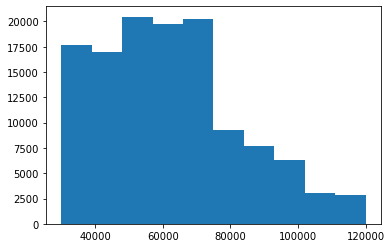

In [87]:
merge=pd.merge(profile,transaction, left_on=['id'], right_on=['person'], how='left')
plt.hist(merge["income"])

#### Gender with Age VS Completed offer

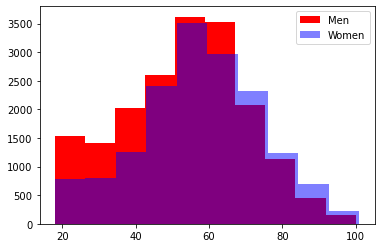

In [98]:
merge=pd.merge(profile,completed, left_on=['id'], right_on=['person'], how='left')
merge_M=merge[merge["gender"]=="M"]
merge_F=merge[merge["gender"]=="F"]

plt.hist(merge_M["age"],color='red', label='Men')
plt.hist(merge_F["age"],color='blue', alpha=0.5, label='Women')
plt.legend()
plt.show()

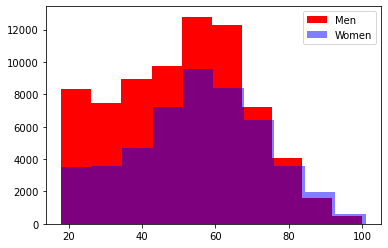

In [99]:
merge=pd.merge(profile,transaction, left_on=['id'], right_on=['person'], how='left')
merge_M=merge[merge["gender"]=="M"]
merge_F=merge[merge["gender"]=="F"]

plt.hist(merge_M["age"],color='red', label='Men')
plt.hist(merge_F["age"],color='blue', alpha=0.5, label='Women')
plt.legend()
plt.show()

#### % Person which they completed a offer, then they follow completed more offers or transactions

In [107]:
merge=pd.merge(profile,completed, left_on=['id'], right_on=['person'], how='left')
merge=merge.sort_values(["time"])
persons_completed=merge["person"].unique()

In [119]:
persons_completed_time=[]
for person in persons_completed:
    print(person*)
    time=merge[merge["person"]==person]["time"].values[0]
    persons_completed_time.append((person,time))

3c68fb5b7d41bab5fe10f320857343
a54f2fe8cd524ee0b7211a2dd6e5dec8
20e1db51ebe94cd9a823bfb84cca99da
751b883d5ea84c289686876ce968350b
e4c03129a4bb4dadb476ab4a4dec775c
098d124614df4e4b862d678160b98638
b8a0e096e34e4281baebc5aead2de945
96804b88f02c468a8cda552b69141a74
293c579998c6419883d2014a26c49415
3d92ee9eb0b444a6bc99e01c46e043ce
e88c17e2c42d432cb8fdb808c85920a2
aaf4e1f165fc4fae9b4583bc0cecb4f1
12a442b1eef2476faee1829aa6e2e1b5
1bead1cdfe3c4be1a0840deceb396be6
facb71d84b5f476c92428d60a73513a8
74e413dfd6f2437788286abfe2bc3f8a
13b05afb8c4249179074ce931636fc70
f81cf50a115f4042b0fe3f09265a56d7
8bd4f1323743436a8cd57db497090a2d
b13a646bdb6a456bbb5bdb4c2d88d7dc
68847bcfe23c4f7681e82e98d22d0b23
a13ec678393e4503958b05b787a2938b
2a18130a7d8e4824a57f2a9ef8c9920b
6746ff7ff11040338898c98b10c84d05
4bbc98fd8048429eb9dbfd856e1288d7
99b18b650c2745489bf81a306852a7c5
ba32af6b9a164643ac73cbc6faa19c3b
33ca79edeaf946929d96acd1d4c1d4eb
afdea41bb33f407fa1bb73033fa5d82b
3622ea602ea242a68bf3bf73df66bbb9
43e90787bd3a

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
persons_completed_time

Max, mode and min of reward and amount

In [ ]:
import statistics

reward=(max(transcript["reward"]),min(transcript["reward"]),statistics.mode(transcript["reward"]))
amount=(max(transcript["amount"]),min(transcript["amount"]),statistics.mode(transcript["amount"]))
valores=[reward,amount]
valores